In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import pandas as pd 
import numpy as np 
import seaborn as sns
import random 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing

tfk = tf.keras
tfkl = tf.keras.layers

Num GPUs Available:  1


In [2]:
BATCH_SIZE = 32
SHAPE = (4096, 23)
BLOCK_SHAPE = (64, 23)
EPOCHS = 30
VARIABLES = 23
NFOLD = 5 
STEPS_PER_EPOCH = 200
ID = 28

In [3]:
if ID == 28:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C28.csv'
elif ID == 37:
    file='D:/Document/DSCI-601/NGAFID/NGAFID_MC_C37.csv'
else:
    print('Invalid ID')
df_test = pd.read_csv(file, nrows=100)
float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float16 for c in float_cols}

df = pd.read_csv(file, dtype=float32_cols, engine='c')
df['id'] = df.id.astype('int32')
df = df.dropna()

In [4]:
sources = df[['id', 'plane_id', 'split', 'date_diff', 'before_after']].drop_duplicates()
sources.loc[: , ['split', 'before_after', 'id']].groupby(['split', 'before_after']).count()

id
split before_after     
0     0             589
      1             484
1     0             555
      1             449
2     0             641
      1             552
3     0             343
      1             282
4     0             456
      1             382

In [5]:
input_columns = ['volt1',
 'volt2',
 'amp1',
 'amp2',
 'FQtyL',
 'FQtyR',
 'E1 FFlow',
 'E1 OilT',
 'E1 OilP',
 'E1 RPM',
 'E1 CHT1',
 'E1 CHT2',
 'E1 CHT3',
 'E1 CHT4',
 'E1 EGT1',
 'E1 EGT2',
 'E1 EGT3',
 'E1 EGT4',
 'OAT',
 'IAS',
 'VSpd',
 'NormAc',
 'AltMSL']

In [6]:
preprocess = preprocessing.MinMaxScaler()
preprocess.fit(df.loc[:, input_columns].sample(100000, random_state = 0 ))
org_value = df.loc[:, input_columns].values
res = preprocess.transform(org_value)
for i, col in enumerate(input_columns):
    df.loc[:, col] = res[:, i]

D:\Python-Anaconda\envs\tf\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [7]:
def get_dataset(df): 

    ids = df.id.unique()

    sensor_datas = []
    afters = [] 

    for id in ids: 
        sensor_data = df[df.id == id].iloc[-SHAPE[0]:, :23].values

        sensor_data = np.pad(sensor_data, [[0, SHAPE[0]- len(sensor_data)], [0,0]])

        sensor_data = tf.convert_to_tensor(sensor_data, dtype = tf.float32) 

        after = df[df.id == id]['before_after'].iloc[0]

        sensor_datas.append(sensor_data)
        afters.append(after)


    sensor_datas = tf.stack(sensor_datas)
    afters = np.stack(afters)

    ds = tf.data.Dataset.from_tensor_slices( (sensor_datas, afters))
    
    return ds

In [8]:
def slice_random(x, y):
    start = tf.random.uniform(shape=[], minval=0, maxval=4096-BLOCK_SHAPE[0], dtype=tf.int64)
    x = x[start: start + BLOCK_SHAPE[0]]
    x = tf.reshape(x, (BLOCK_SHAPE))
    return x, y 

In [9]:
def fix_type(x, y):

    return tf.cast(x, tf.float32), tf.cast(y, tf.float32)

In [10]:
def prepare_for_training(ds, shuffle = False, repeat = False, predict= True):
    
    ds = ds.map(fix_type)
    ds = ds.map(slice_random)

    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds 
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)

    if not predict: 
        ds = ds.map(lambda x, y : (x, x) ) 
    else: 
        ds = ds.map(lambda x, y : (x, tf.reshape(y, (-1, 1))) )
         
    return ds

In [11]:
def get_train_and_val_for_fold(folded_datasets, fold):
    predict = True

    train = []
    for i in range(NFOLD-1): 
        if i == fold:
            val_ds = folded_datasets[i][0].concatenate(folded_datasets[i][1])
        else: 
            train.append(folded_datasets[i][0])
    
    test_ds = folded_datasets[4][0].concatenate(folded_datasets[4][1])
    
    train_ds = None
    for ds in train: 
        train_ds = ds if train_ds is None else train_ds.concatenate(ds)

    test_ds = prepare_for_training(test_ds, shuffle=False)
    train_ds = prepare_for_training(train_ds, shuffle=True, repeat = True)
    val_ds = prepare_for_training(val_ds, shuffle=False)
    
    return train_ds, val_ds, test_ds

In [12]:
folded_datasets = []

for i in range(NFOLD):
    after = get_dataset(df[(df.split == i) & (df.before_after == 1)])
    before = get_dataset(df[(df.split == i) & (df.before_after == 0)])
    folded_datasets.append((after, before))

In [13]:
class Autoencoder(tfk.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tfk.Sequential([
            tfkl.Input(shape = BLOCK_SHAPE),
            tfkl.Conv1D(256, 3, activation='relu', padding='same', strides=2),
            tfkl.Conv1D(128, 3, activation='relu', padding='same', strides=2),
            tfkl.Conv1D(64, 3, activation='relu', padding='same', strides=2),
            tfkl.Conv1D(32, 3, activation='relu', padding='same', strides=2),
        ])
        
        self.decoder = tf.keras.Sequential([
            tfkl.Conv1DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(64, kernel_size=3, strides=2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(128, kernel_size=3, strides=2, activation='relu', padding='same'),
            tfkl.Conv1DTranspose(256, kernel_size=3, strides=2, activation='relu', padding='same'),
            tfkl.Conv1D(1, kernel_size=3, activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [14]:
class Conv1D(tfk.Model):
    def __init__(self):
        super(Conv1D, self).__init__()
        self.conv1D_model = tfk.Sequential([
            tfkl.Input(shape = BLOCK_SHAPE),
            tfkl.Conv1D(64, 3, activation='relu', padding='same', strides=2),
            tfkl.Conv1D(64, 3, activation='relu', padding='same', strides=2),
            tfkl.Conv1D(64, 3, activation='relu', padding='same', strides=2),
            tfkl.Conv1D(64, 3, activation='relu', padding='same', strides=2),
            tfkl.GlobalAveragePooling1D(),
            tfkl.Dense(1, activation='sigmoid'),
        ])
            
    def call(self, x):
        conv1D = self.conv1D_model(x)
        return conv1D

In [15]:
cnn1D_encoder_result = {}
for i in range(NFOLD-1):
    autoencoder = Autoencoder()
    autoencoder.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', 
                                   tfk.metrics.RootMeanSquaredError(),
                                  ],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = autoencoder.fit(train_dataset, epochs= EPOCHS,steps_per_epoch = STEPS_PER_EPOCH,validation_data= val_dataset,)
    
    cnn1D_encoder_result[i] = result.history

pd.DataFrame(cnn1D_encoder_result)

Epoch 1/30
200/200 [==============================] - 24s 12ms/step - loss: 0.2490 - accuracy: 0.9086 - root_mean_squared_error: 0.4990 - val_loss: 0.2502 - val_accuracy: 0.4584 - val_root_mean_squared_error: 0.5002
Epoch 2/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2472 - accuracy: 1.0000 - root_mean_squared_error: 0.4972 - val_loss: 0.2504 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5004
Epoch 3/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2444 - accuracy: 1.0000 - root_mean_squared_error: 0.4944 - val_loss: 0.2507 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5007
Epoch 4/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2400 - accuracy: 1.0000 - root_mean_squared_error: 0.4899 - val_loss: 0.2512 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5012
Epoch 5/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2333 - accuracy: 1.0000 - root_mean_squared_error: 0.4831 - va

Epoch 8/30
200/200 [==============================] - 2s 10ms/step - loss: 0.1847 - accuracy: 1.0000 - root_mean_squared_error: 0.4297 - val_loss: 0.2660 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5158
Epoch 9/30
200/200 [==============================] - 2s 9ms/step - loss: 0.1603 - accuracy: 1.0000 - root_mean_squared_error: 0.4004 - val_loss: 0.2774 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5267
Epoch 10/30
200/200 [==============================] - 2s 10ms/step - loss: 0.1342 - accuracy: 1.0000 - root_mean_squared_error: 0.3663 - val_loss: 0.2937 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5419
Epoch 11/30
200/200 [==============================] - 2s 10ms/step - loss: 0.1078 - accuracy: 1.0000 - root_mean_squared_error: 0.3284 - val_loss: 0.3153 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5615
Epoch 12/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0842 - accuracy: 1.0000 - root_mean_squared_error: 0.2902 - v

200/200 [==============================] - 2s 10ms/step - loss: 0.0479 - accuracy: 1.0000 - root_mean_squared_error: 0.2188 - val_loss: 0.3791 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6157
Epoch 16/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0380 - accuracy: 1.0000 - root_mean_squared_error: 0.1949 - val_loss: 0.4026 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6345
Epoch 17/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0304 - accuracy: 1.0000 - root_mean_squared_error: 0.1744 - val_loss: 0.4176 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6462
Epoch 18/30
200/200 [==============================] - 2s 10ms/step - loss: 0.0250 - accuracy: 1.0000 - root_mean_squared_error: 0.1581 - val_loss: 0.4315 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6569ss: 0.0259 - accuracy: 1.0000 - root_mean_squared - ETA: 0s - loss: 0.0253 - accuracy: 1.0000 - root_mean_squared_e
Epoch 19/30
200/200 [============

200/200 [==============================] - 2s 9ms/step - loss: 0.0141 - accuracy: 1.0000 - root_mean_squared_error: 0.1189 - val_loss: 0.4761 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6900
Epoch 23/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0131 - accuracy: 1.0000 - root_mean_squared_error: 0.1143 - val_loss: 0.4874 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6981
Epoch 24/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0120 - accuracy: 1.0000 - root_mean_squared_error: 0.1095 - val_loss: 0.4906 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7004
Epoch 25/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0105 - accuracy: 1.0000 - root_mean_squared_error: 0.1026 - val_loss: 0.4925 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.7018
Epoch 26/30
200/200 [==============================] - 2s 9ms/step - loss: 0.0105 - accuracy: 1.0000 - root_mean_squared_error: 0.1025 - val_loss: 0.500

,0,1,2,3
loss,"[0.2489517778158188, 0.24719133973121643, 0.24...","[0.24864277243614197, 0.24669288098812103, 0.2...","[0.2493765652179718, 0.2477276474237442, 0.245...","[0.2484833002090454, 0.24629804491996765, 0.24..."
accuracy,"[0.9086499214172363, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.9030835032463074, 0.9999926686286926, 1.0, ...","[0.7561938762664795, 0.9844262599945068, 0.999...","[0.906872570514679, 0.9917065501213074, 1.0, 1..."
root_mean_squared_error,"[0.49895066022872925, 0.4971834123134613, 0.49...","[0.4986409544944763, 0.49668189883232117, 0.49...","[0.49937617778778076, 0.49772244691848755, 0.4...","[0.49848097562789917, 0.49628424644470215, 0.4..."
val_loss,"[0.2501509487628937, 0.2503601908683777, 0.250...","[0.25021854043006897, 0.25044339895248413, 0.2...","[0.25009891390800476, 0.25023919343948364, 0.2...","[0.250206857919693, 0.2504196763038635, 0.2508..."
val_accuracy,"[0.4583629369735718, 0.4583333432674408, 0.458...","[0.45247921347618103, 0.4526209533214569, 0.45...","[0.4693702459335327, 0.4661106467247009, 0.466...","[0.46736225485801697, 0.4638157784938812, 0.46..."
val_root_mean_squared_error,"[0.5001509189605713, 0.5003600716590881, 0.500...","[0.5002184510231018, 0.500443160533905, 0.5009...","[0.5000989437103271, 0.5002391338348389, 0.500...","[0.5002068281173706, 0.5004194974899292, 0.500..."


In [16]:
cnnv1D_result = {}
for i in range(NFOLD-1):
    conv1D = Conv1D()
    conv1D.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-6), 
                        metrics = ['accuracy', tfk.metrics.RootMeanSquaredError(),],
                        loss = tfk.losses.MeanSquaredError(reduction= tfk.losses.Reduction.SUM_OVER_BATCH_SIZE)
                       )
    train_dataset, val_dataset, test_dataset = get_train_and_val_for_fold(folded_datasets=folded_datasets,fold = i)   
    
    result = conv1D.fit(train_dataset, epochs= EPOCHS,steps_per_epoch = STEPS_PER_EPOCH,validation_data= val_dataset,)
    
    cnnv1D_result[i] = result.history

pd.DataFrame(cnnv1D_result)

Epoch 1/30
200/200 [==============================] - 2s 7ms/step - loss: 0.2427 - accuracy: 0.8583 - root_mean_squared_error: 0.4927 - val_loss: 0.2512 - val_accuracy: 0.4678 - val_root_mean_squared_error: 0.5012
Epoch 2/30
200/200 [==============================] - 1s 7ms/step - loss: 0.2283 - accuracy: 0.9911 - root_mean_squared_error: 0.4778 - val_loss: 0.2526 - val_accuracy: 0.4612 - val_root_mean_squared_error: 0.5026
Epoch 3/30
200/200 [==============================] - 1s 7ms/step - loss: 0.2135 - accuracy: 0.9992 - root_mean_squared_error: 0.4621 - val_loss: 0.2558 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5058
Epoch 4/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1993 - accuracy: 1.0000 - root_mean_squared_error: 0.4464 - val_loss: 0.2591 - val_accuracy: 0.4583 - val_root_mean_squared_error: 0.5090
Epoch 5/30
200/200 [==============================] - 1s 7ms/step - loss: 0.1854 - accuracy: 1.0000 - root_mean_squared_error: 0.4305 - val_loss

200/200 [==============================] - 1s 7ms/step - loss: 0.1105 - accuracy: 1.0000 - root_mean_squared_error: 0.3324 - val_loss: 0.3016 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5492
Epoch 10/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0971 - accuracy: 1.0000 - root_mean_squared_error: 0.3115 - val_loss: 0.3141 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5604
Epoch 11/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0857 - accuracy: 1.0000 - root_mean_squared_error: 0.2927 - val_loss: 0.3247 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5698
Epoch 12/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0748 - accuracy: 1.0000 - root_mean_squared_error: 0.2734 - val_loss: 0.3342 - val_accuracy: 0.4526 - val_root_mean_squared_error: 0.5781
Epoch 13/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0648 - accuracy: 1.0000 - root_mean_squared_error: 0.2545 - val_loss: 0.346

200/200 [==============================] - 1s 7ms/step - loss: 0.0696 - accuracy: 1.0000 - root_mean_squared_error: 0.2638 - val_loss: 0.3299 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.5744
Epoch 18/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0623 - accuracy: 1.0000 - root_mean_squared_error: 0.2495 - val_loss: 0.3411 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.5841
Epoch 19/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0556 - accuracy: 1.0000 - root_mean_squared_error: 0.2357 - val_loss: 0.3486 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.5905
Epoch 20/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0496 - accuracy: 1.0000 - root_mean_squared_error: 0.2226 - val_loss: 0.3600 - val_accuracy: 0.4662 - val_root_mean_squared_error: 0.6000
Epoch 21/30
200/200 [==============================] - 1s 7ms/step - loss: 0.0434 - accuracy: 1.0000 - root_mean_squared_error: 0.2084 - val_loss: 0.370

200/200 [==============================] - 1s 6ms/step - loss: 0.0385 - accuracy: 1.0000 - root_mean_squared_error: 0.1963 - val_loss: 0.3811 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6173
Epoch 26/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0345 - accuracy: 1.0000 - root_mean_squared_error: 0.1856 - val_loss: 0.3970 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6301
Epoch 27/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0299 - accuracy: 1.0000 - root_mean_squared_error: 0.1729 - val_loss: 0.4018 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6338
Epoch 28/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0275 - accuracy: 1.0000 - root_mean_squared_error: 0.1659 - val_loss: 0.4137 - val_accuracy: 0.4638 - val_root_mean_squared_error: 0.6432
Epoch 29/30
200/200 [==============================] - 1s 6ms/step - loss: 0.0254 - accuracy: 1.0000 - root_mean_squared_error: 0.1592 - val_loss: 0.419

,0,1,2,3
loss,"[0.24271094799041748, 0.2283230721950531, 0.21...","[0.20894846320152283, 0.19926175475120544, 0.1...","[0.244338259100914, 0.23607486486434937, 0.227...","[0.25397953391075134, 0.24416181445121765, 0.2..."
accuracy,"[0.8582812547683716, 0.9910937547683716, 0.999...","[0.9998437762260437, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.9076562523841858, 0.9976562261581421, 1.0, ...","[0.24718749523162842, 0.8870312571525574, 0.99..."
root_mean_squared_error,"[0.49265703558921814, 0.47783163189888, 0.4621...","[0.45710882544517517, 0.4463874399662018, 0.43...","[0.494305819272995, 0.48587536811828613, 0.476...","[0.503963828086853, 0.4941273033618927, 0.4843..."
val_loss,"[0.2512299120426178, 0.2526107728481293, 0.255...","[0.2562864124774933, 0.25906676054000854, 0.26...","[0.25065335631370544, 0.25136545300483704, 0.2...","[0.24992001056671143, 0.2508458197116852, 0.25..."
val_accuracy,"[0.467803031206131, 0.46117424964904785, 0.458...","[0.4526209533214569, 0.4526209533214569, 0.452...","[0.47043919563293457, 0.46621620655059814, 0.4...","[0.48355263471603394, 0.4638157784938812, 0.46..."
val_root_mean_squared_error,"[0.501228392124176, 0.5026040077209473, 0.5057...","[0.5062474012374878, 0.5089859962463379, 0.512...","[0.5006529092788696, 0.5013635754585266, 0.502...","[0.4999200105667114, 0.5008450746536255, 0.501..."


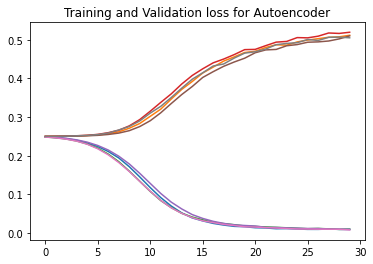

In [17]:
for i in range(NFOLD-1):
    loss = cnn1D_encoder_result[i]['loss']
    val_loss = cnn1D_encoder_result[i]['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Training and Validation loss for Autoencoder')

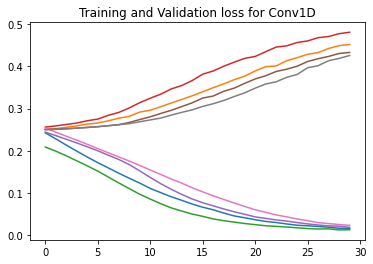

In [18]:
for i in range(NFOLD-1):
    loss = cnnv1D_result[i]['loss']
    val_loss = cnnv1D_result[i]['val_loss']
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Training and Validation loss for Conv1D')

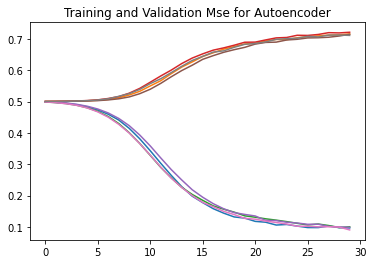

In [19]:
for i in range(NFOLD-1):
    mse = cnn1D_encoder_result[i]['root_mean_squared_error']
    val_mse = cnn1D_encoder_result[i]['val_root_mean_squared_error']
    plt.plot(mse)
    plt.plot(val_mse)
    plt.title('Training and Validation Mse for Autoencoder')

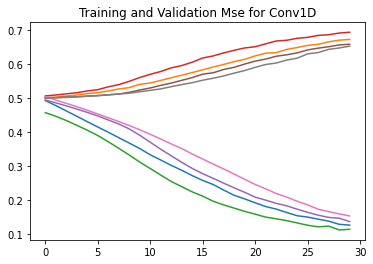

In [20]:
for i in range(NFOLD-1):
    mse = cnnv1D_result[i]['root_mean_squared_error']
    val_mse = cnnv1D_result[i]['val_root_mean_squared_error']
    plt.plot(mse)
    plt.plot(val_mse)
    plt.title('Training and Validation Mse for Conv1D')

26/26 [==============================] - 1s 3ms/step


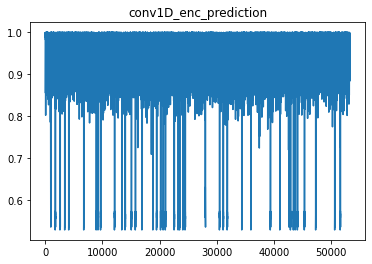

In [21]:
cnn1D_enc_predict = autoencoder.predict(test_dataset, verbose = True)
cnn1D_enc_predict = cnn1D_enc_predict.reshape(-1)
plt.title("conv1D_enc_prediction")
plt.plot(cnn1D_enc_predict)

26/26 [==============================] - 0s 2ms/step


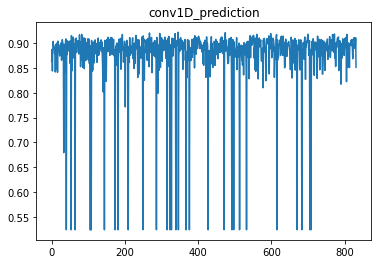

In [22]:
conv1D_predict = conv1D.predict(test_dataset, verbose = True)
plt.title("conv1D_prediction")
plt.plot(conv1D_predict)